# Boilerplate functions

## Make sure that tensorflow works

In [89]:
reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [90]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

import tensorflow as tf
sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 3313048255416200059
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 12626830996448656313
physical_device_desc: "device: XLA_CPU device"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 12012746113559161587
physical_device_desc: "device: XLA_GPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 7433374925
locality {
  bus_id: 1
  links {
  }
}
incarnation: 2372932474907145755
physical_device_desc: "device: 0, name: GeForce RTX 2070, pci bus id: 0000:01:00.0, compute capability: 7.5"
]


In [91]:
from scipy.io import loadmat
import numpy as np
import matplotlib.pyplot as plt
import time
from matplotlib.pyplot import imshow

import tensorflow as tf
import re
import numpy as np
import Image
from sklearn.model_selection import train_test_split
import matplotlib.pylab as pylab
from matplotlib.ticker import MaxNLocator

%matplotlib inline

In [92]:
import tensorflow as tf
with tf.device('/gpu:0'):
    a = tf.constant([1.0, 2.0, 3.0, 4.0, 5.0, 6.0], shape=[2, 3], name='a')
    b = tf.constant([1.0, 2.0, 3.0, 4.0, 5.0, 6.0], shape=[3, 2], name='b')
    c = tf.matmul(a, b)

with tf.Session() as sess:
    print (sess.run(c))

[[ 22.  28.]
 [ 49.  64.]]


In [93]:
# Creates a graph.
a = tf.constant([1.0, 2.0, 3.0, 4.0, 5.0, 6.0], shape=[2, 3], name='a')
b = tf.constant([1.0, 2.0, 3.0, 4.0, 5.0, 6.0], shape=[3, 2], name='b')
c = tf.matmul(a, b)
# Creates a session with log_device_placement set to True.
sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))
# Runs the op.
print(sess.run(c))


[[ 22.  28.]
 [ 49.  64.]]


## Import Keras

In [94]:
from keras import backend as k
from keras.layers import Activation
from keras.layers import Input, Dense, Lambda, Dropout, Convolution2D, MaxPooling2D, Flatten,Conv2D
from keras.models import Sequential, Model
from keras.optimizers import RMSprop
from keras.utils import to_categorical


# Let's read the data

In [95]:
train_file = loadmat('../STL10/stl10_matlab/train.mat')
test_file = loadmat('../STL10/stl10_matlab/test.mat')

print("Train File :" ,train_file.keys())
print("Test File :",test_file.keys())

('Train File :', ['__header__', '__globals__', 'fold_indices', 'y', 'X', '__version__', 'class_names'])
('Test File :', ['__header__', '__globals__', 'y', 'X', '__version__', 'class_names'])


## Get the train and test images

In [ ]:
# # train_images = train_file['X'] #5000 training images ((5000, 27648))
# test_images = test_file['X'] #8000 test images ((8000, 27648))
# print(test_images.shape)

### The images need to be reshaped for VGG

In [ ]:
train_images_reshaped = np.transpose(np.reshape(train_images,(-1,3,96,96)),(0,3,2,1))
#-1 lets numpy determine the size on its own
test_images_reshaped = np.transpose(np.reshape(test_images,(-1,3,96,96)),(0,3,2,1))

print(train_images_reshaped.shape)
print(test_images_reshaped.shape)

print(train_images_reshaped[5].shape) #images is 96x96 with 3 colored channels
imshow(train_images_reshaped[5])
plt.show()
imshow(test_images_reshaped[5])

In [ ]:
del train_images,test_images

In [ ]:
#splitting the test image set because it causes memory errors during pre-processing
test_images_reshaped_1 = test_images_reshaped[:4000]
test_images_reshaped_2 = test_images_reshaped[4000:]
del test_images_reshaped

In [ ]:
imshow(train_images_reshaped[5])
plt.show()
imshow(test_images_reshaped_1[5])

## Resize the images

In [ ]:
import os, sys, tarfile, time
from PIL import Image

def resize_tensorimages(X_raw, interp_method=Image.BICUBIC):
    # VGG16 accepts input images of size (224, 224, 3)
    # Therefore, convert X_train_raw and X_test_raw to PIL.Image format, 
    # then resize the images from (96, 96, 3) to (224, 224, 3) 
    
    # X_224 = np.zeros((X_raw.shape[0], 224, 224, 3)) --this takes up too much RAM
    X_224 = [] #creates a list
    for i, _ in enumerate(X_raw):
        im = Image.fromarray(np.uint8(X_raw[i]))
        img = im.resize((224, 224), interp_method)
        arr = np.array(img)
        X_224.append(arr)
    
    return np.asarray(X_224)

In [ ]:
# X_train  = resize_tensorimages(train_images_reshaped)
# del train_images_reshaped

In [ ]:
# X_test_1 = resize_tensorimages(test_images_reshaped_1)
# del test_images_reshaped_1

In [ ]:
# X_test_2 = resize_tensorimages(test_images_reshaped_2)
# del test_images_reshaped_2

### Import the VGG Model

In [96]:
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
#---------------------------------------------------------

model_bottom = VGG16(include_top=False)

#### Preprocess training images for VGG

In [ ]:
X_train = preprocess_input(X_train)

In [ ]:
d = model_bottom.predict(X_train[0:2])

In [62]:
print type(d)
print d.shape
print type(d.shape[1])

<type 'numpy.ndarray'>
(2, 7, 7, 512)
<type 'int'>


In [63]:
X_train_features = np.zeros((X_train.shape[0],d.shape[1],d.shape[2],d.shape[3]))

In [100]:

from __future__ import division
batch_size = 128

for i in range(len(X_train)//batch_size):
    idx = range(i*batch_size, (i+1)*batch_size)
    print('Training set: %5.2f%%' % ((i+1)/(len(X_train)/batch_size)*100))
    X_train_features[idx] = model_bottom.predict(X_train[idx])    
X_train_features[(i+1)*batch_size:] = model_bottom.predict(X_train[(i+1)*batch_size:])

Training set:  2.56%
Training set:  5.12%
Training set:  7.68%
Training set: 10.24%
Training set: 12.80%
Training set: 15.36%
Training set: 17.92%
Training set: 20.48%
Training set: 23.04%
Training set: 25.60%
Training set: 28.16%
Training set: 30.72%
Training set: 33.28%
Training set: 35.84%
Training set: 38.40%
Training set: 40.96%
Training set: 43.52%
Training set: 46.08%
Training set: 48.64%
Training set: 51.20%
Training set: 53.76%
Training set: 56.32%
Training set: 58.88%
Training set: 61.44%
Training set: 64.00%
Training set: 66.56%
Training set: 69.12%
Training set: 71.68%
Training set: 74.24%
Training set: 76.80%
Training set: 79.36%
Training set: 81.92%
Training set: 84.48%
Training set: 87.04%
Training set: 89.60%
Training set: 92.16%
Training set: 94.72%
Training set: 97.28%
Training set: 99.84%


In [106]:
np.save('../STL10/data/X_train_features',X_train_features)
del X_train_features

#### Preprocessing test images for VGG

In [35]:
X_test_1 = preprocess_input(X_test_1)
X_test_2 = preprocess_input(X_test_2)

In [37]:
X_test_features_1 = np.zeros((X_test_1.shape[0],7,7,512))
X_test_features_2 = np.zeros((X_test_2.shape[0],7,7,512))

In [38]:
from __future__ import division
batch_size = 128

for i in range(len(X_test_1)//batch_size):
    idx = range(i*batch_size, (i+1)*batch_size)
    print('Test set 1: %5.2f%%' % ((i+1)/(len(X_test_1)/batch_size)*100))
    X_test_features_1[idx] = model_bottom.predict(X_test_1[idx])    
X_test_features_1[(i+1)*batch_size:] = model_bottom.predict(X_test_1[(i+1)*batch_size:])

Test set 1:  3.20%
Test set 1:  6.40%
Test set 1:  9.60%
Test set 1: 12.80%
Test set 1: 16.00%
Test set 1: 19.20%
Test set 1: 22.40%
Test set 1: 25.60%
Test set 1: 28.80%
Test set 1: 32.00%
Test set 1: 35.20%
Test set 1: 38.40%
Test set 1: 41.60%
Test set 1: 44.80%
Test set 1: 48.00%
Test set 1: 51.20%
Test set 1: 54.40%
Test set 1: 57.60%
Test set 1: 60.80%
Test set 1: 64.00%
Test set 1: 67.20%
Test set 1: 70.40%
Test set 1: 73.60%
Test set 1: 76.80%
Test set 1: 80.00%
Test set 1: 83.20%
Test set 1: 86.40%
Test set 1: 89.60%
Test set 1: 92.80%
Test set 1: 96.00%
Test set 1: 99.20%


In [40]:
np.save('../STL10/data/X_test_features_1',X_test_features_1)
del X_test_features_1

In [43]:
from __future__ import division
batch_size = 128

for i in range(len(X_test_2)//batch_size):
    idx = range(i*batch_size, (i+1)*batch_size)
    print('Test set 2: %5.2f%%' % ((i+1)/(len(X_test_2)/batch_size)*100))
    X_test_features_2[idx] = model_bottom.predict(X_test_2[idx])    
X_test_features_2[(i+1)*batch_size:] = model_bottom.predict(X_test_2[(i+1)*batch_size:])

Test set 2:  3.20%
Test set 2:  6.40%
Test set 2:  9.60%
Test set 2: 12.80%
Test set 2: 16.00%
Test set 2: 19.20%
Test set 2: 22.40%
Test set 2: 25.60%
Test set 2: 28.80%
Test set 2: 32.00%
Test set 2: 35.20%
Test set 2: 38.40%
Test set 2: 41.60%
Test set 2: 44.80%
Test set 2: 48.00%
Test set 2: 51.20%
Test set 2: 54.40%
Test set 2: 57.60%
Test set 2: 60.80%
Test set 2: 64.00%
Test set 2: 67.20%
Test set 2: 70.40%
Test set 2: 73.60%
Test set 2: 76.80%
Test set 2: 80.00%
Test set 2: 83.20%
Test set 2: 86.40%
Test set 2: 89.60%
Test set 2: 92.80%
Test set 2: 96.00%
Test set 2: 99.20%


In [44]:
np.save('../STL10/data/X_test_features_2',X_test_features_2)
del X_test_features_2

## Get the train and test labels

In [97]:
train_labels = train_file['y']
test_labels = test_file['y']
class_labels = test_file['class_names']
# print(train_labels.shape) #5000 labels for 5000 images ((5000,1))
# print(min(train_labels),max(train_labels)) #class labels go from 1-10.


#Let's re-adjust the labels to be from 0 to 9
train_labels_adjusted = train_labels - 1
test_labels_adjusted = test_labels - 1
# print(min(train_labels_adjusted),max(train_labels_adjusted)) #Class labels adjuested goes from 0 to 9


In [98]:
del train_file,test_file

In [99]:
print type(class_labels)

<type 'numpy.ndarray'>


In [100]:
print np.asarray(class_labels)

[[array([u'airplane'],
      dtype='<U8')
  array([u'bird'],
      dtype='<U4') array([u'car'],
      dtype='<U3')
  array([u'cat'],
      dtype='<U3') array([u'deer'],
      dtype='<U4')
  array([u'dog'],
      dtype='<U3') array([u'horse'],
      dtype='<U5')
  array([u'monkey'],
      dtype='<U6') array([u'ship'],
      dtype='<U4')
  array([u'truck'],
      dtype='<U5')]]


In [101]:
y_train = to_categorical(train_labels_adjusted, num_classes = 1000)
y_test  = to_categorical(test_labels_adjusted , num_classes = 1000)

In [102]:
print(y_train.shape)#remember this was 5000x1 earlier and to categorical changed this to one-hot encoding

(5000, 1000)


In [117]:
X_train_features = np.load('../STL10/data/X_train_features.npy')
X_test_features1 = np.load('../STL10/data/X_test_features_1.npy')
X_test_features2 = np.load('../STL10/data/X_test_features_2.npy')

In [118]:
idx = list(range(13000))
np.random.shuffle(idx)
X_all = np.concatenate([X_train_features, X_test_features1, X_test_features2])
y_all = np.concatenate([y_train, y_test])

X_train_features = X_all[idx[:5000]]
y_train = y_all[idx[:5000]]
X_test_features = X_all[idx[5000:]]
y_test = y_all[idx[5000:]]

del X_all, y_all


In [119]:
del X_test_features1,X_test_features2 

## Printing stuff to learn

In [16]:
# y_train[0][:100]
# y_temp = np.argmax(y_train,axis = 1)
# print(y_train[1][:100]) #5th index is 1
# print(y_temp[1])# this will store the index 5 after argmax

[ 0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
5


In [27]:
# # print(set(y_temp)) #there are 10 classes in our dataset
# idx = []
# for cls in set(y_temp):
#     idx.append(np.where(y_temp==cls)[0])
# print(type(idx))#list
# print(len(idx))#list of 10 classes
# print(type(idx[0]))#each list element is an array
# print(len(idx[0]))# each class has 500 numbers
# idx = np.asarray(idx)
# print(idx.shape)#convert to 10x500 array


<type 'list'>
10
<type 'numpy.ndarray'>
500
(10, 500)


# Write helper functions

In [103]:
def custom_KFold(y_onehot, n_split=5):
    y = np.argmax(y_onehot, axis=1)
    #axis 1 looks at all columns within the row
    #so for each image we get the max index
    # input y: numpy array of class ID's
    
    idx = []
    for cls in set(y):
        # idx[cls] is the indices to class no cls
        # Idx will store indices where each class label is true
        # so 1st 500 idx will have indices where class label is 0, next 500 will be for class label 1 and so on
        idx.append(np.where(y==cls)[0])
        
    idx = np.asarray(idx)
    for i in range(len(idx)):#will go from 0 to 9 for 10 classes
        np.random.shuffle(idx[i]) #shuffle the images with in each class

    fidx = []
    fold_width = int(idx.shape[1]/n_split)#for each class we want to split the images into n_splits
    
    for k in range(n_split):
        out = []
        
        #get kth fold for each class
        for i in range(len(idx)):#loops 10 times *same as number of class*
            out.append(idx[i,k*fold_width : (k+1)*fold_width])
        
        #combine the kth fold of 10 classes and shuffle it
        out = np.concatenate(out)
        np.random.shuffle(out)
        
        #store the the kth fold in fidx
        fidx.append(out)
    
    fidx = np.array(fidx)
    np.random.shuffle(fidx)
    return fidx

In [104]:
def get_cnames_fidx(y_onehot, n_split=5):
    # Returns
    # fidx: fold indices on the training set (0,...4999)
    # cnames: class names (10 classes)
    
    cnames = class_labels

    fidx = custom_KFold(y_onehot, n_split=n_split)
    
    print('Class names retrieved in cnames')
    print('K-Fold indices generated, n_split = %i'%(n_split))
    print('Fold width = %i'%(fidx.shape[1]))
    print('Number of data points for each class = %i'%(fidx.shape[1]/n_split))
    return cnames, fidx

In [105]:
cnames, fidx = get_cnames_fidx(y_train, n_split=5)
print('All labeled data loaded.')

Class names retrieved in cnames
K-Fold indices generated, n_split = 5
Fold width = 1000
Number of data points for each class = 200
All labeled data loaded.


In [111]:
import sys

# These are the usual ipython objects, including this one you are creating
ipython_vars = ['In', 'Out', 'exit', 'quit', 'get_ipython', 'ipython_vars']

# Get a sorted list of the objects and their sizes
sorted([(x, sys.getsizeof(globals().get(x))) for x in dir() if not x.startswith('_') and x not in sys.modules and x not in ipython_vars], key=lambda x: x[1], reverse=True)

[('fidx', 40112),
 ('test_labels_adjusted', 8112),
 ('train_labels_adjusted', 5112),
 ('Activation', 904),
 ('Callback', 904),
 ('Callback_Func', 904),
 ('Conv2D', 904),
 ('Convolution2D', 904),
 ('Dense', 904),
 ('Dropout', 904),
 ('Flatten', 904),
 ('Lambda', 904),
 ('MaxNLocator', 904),
 ('MaxPooling2D', 904),
 ('Model', 904),
 ('RMSprop', 904),
 ('Sequential', 904),
 ('Input', 120),
 ('VGG16', 120),
 ('construct_model', 120),
 ('custom_KFold', 120),
 ('get_cnames_fidx', 120),
 ('imshow', 120),
 ('loadmat', 120),
 ('plotter', 120),
 ('preprocess_input', 120),
 ('print_runtime', 120),
 ('to_categorical', 120),
 ('train_model', 120),
 ('train_test_split', 120),
 ('class_labels', 112),
 ('cnames', 112),
 ('test_labels', 112),
 ('train_labels', 112),
 ('y_test', 112),
 ('y_train', 112),
 ('a', 64),
 ('b', 64),
 ('c', 64),
 ('model_bottom', 64),
 ('sess', 64),
 ('device_lib', 56),
 ('k', 56),
 ('np', 56),
 ('plt', 56),
 ('pylab', 56),
 ('tf', 56)]

In [112]:
def construct_model():
    from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
    from keras.layers import Dropout, Flatten, Dense
    from keras.models import Sequential

    model_top = Sequential() 
    model_top.add(GlobalAveragePooling2D(data_format='channels_last', input_shape=(7, 7, 512))) 
    # model_top.add(Dense(1000, activation='relu')) 
    model_top.add(Dense(1000, activation='relu')) 
    model_top.add(Dense(1000, activation='softmax')) 


    model_top.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy']) 

    return model_top

In [113]:
def train_model(model_top, 
                X_train, y_train,
                X_cv, y_cv,
                epochs=20,
                batch_size=128,
                wanna_plot=False,
                fpath='model'):
    
    start = time.time()
    from keras.callbacks import ModelCheckpoint  
    print('Initiate Training....')
    # ..................................................................
    
    callback_inst = Callback_Func((X_train, y_train),(X_cv, y_cv), start, wanna_plot=wanna_plot)

    checkpointer = ModelCheckpoint(filepath='../STL10/data/saved_models/' + fpath + '.best.hdf5', 
                                   verbose=1, save_best_only=True)

    model_top.fit(X_train, y_train, 
              validation_data=(X_cv, y_cv),
              epochs=epochs, 
              batch_size=batch_size, 
              callbacks=[callback_inst, checkpointer], 
              verbose=0)

    print_runtime(start)

    return model_top, callback_inst

In [114]:
from keras.callbacks import Callback
class Callback_Func(Callback):
    def __init__(self, train_data, test_data, start, wanna_plot=True):
        self.train_data = train_data
        self.test_data = test_data
        self.loss_train = []
        self.loss_test = []
        self.acc = []
        self.start = start
        self.wanna_plot = wanna_plot
        
        
    def plotter(self, title='validation accuracy'):
        ax = plt.subplot(121)
        plt.xlabel('epochs')
        plt.grid('on')
        plt.title('loss')
        x_plot = range(1, len(self.loss_train)+1)
        plt.xlim((1,max(max(x_plot),2)))
        ax.xaxis.set_major_locator(MaxNLocator(integer=True))
        ax.plot(x_plot, self.loss_test, 'r--^', alpha=.7, label="validation")
        ax.plot(x_plot, self.loss_train, 'k--^', alpha=.7, label="train")
        plt.legend()

        ax = plt.subplot(122)
        plt.xlabel('epochs')
        plt.grid('on')
        ax.plot(x_plot, self.acc, 'b--^', alpha=.5)
        plt.xlim((1,max(max(x_plot),2)))
        ax.xaxis.set_major_locator(MaxNLocator(integer=True))
        plt.title(title)
        plt.ion()
        plt.show()


    def on_epoch_end(self, epoch, logs={}):
        X_train, y_train = self.train_data
        X_test, y_test = self.test_data
        _loss_train, _ = self.model.evaluate(X_train, y_train, batch_size=1024, verbose=0)
        _loss_test, _acc = self.model.evaluate(X_test, y_test, batch_size=1024, verbose=0)
        self.loss_train.append(_loss_train)
        self.loss_test.append(_loss_test)
        self.acc.append(_acc)
        
        
        if self.wanna_plot: 
            self.plotter()
            end = time.time()
            print('\nRuntime: %d min %d sec' % ((end-self.start)//60, (end-self.start)%60))
        
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 

In [115]:
def plotter(xlabel=None, ylabel=None, title=None, xlim=None, ylim=None):
    fig = plt.figure()
    ax = plt.gca() # gets current axis
    fig.set_size_inches((15,5))
    plt.grid('on')
    if xlabel: plt.xlabel(xlabel)
    if ylabel: plt.ylabel(ylabel)
    if xlim: plt.xlim((0, xlim));
    if ylim: plt.ylim((0, ylim));
    if title: plt.title(title)
    return fig, ax

In [116]:

def print_runtime(start):
    end = time.time()
    print('Runtime: %d min %d sec' % ((end-start)//60, (end-start)%60))

# train the model

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average_pooling2d_9 ( (None, 512)               0         
_________________________________________________________________
dense_17 (Dense)             (None, 1000)              513000    
_________________________________________________________________
dense_18 (Dense)             (None, 1000)              1001000   
Total params: 1,514,000
Trainable params: 1,514,000
Non-trainable params: 0
_________________________________________________________________
Initiate Training....

Epoch 00001: val_loss improved from inf to 0.31953, saving model to ../STL10/data/saved_models/model.best.hdf5

Epoch 00002: val_loss improved from 0.31953 to 0.23396, saving model to ../STL10/data/saved_models/model.best.hdf5

Epoch 00003: val_loss did not improve from 0.23396

Epoch 00004: val_loss did not improve from 0.23396

Epoch 00005: val_loss improved from 0.233

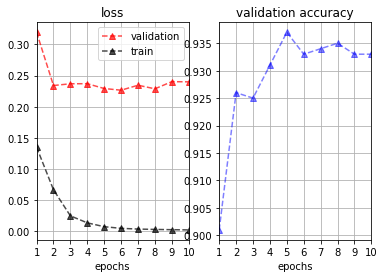

Initiate Training....

Epoch 00001: val_loss improved from inf to 0.22252, saving model to ../STL10/data/saved_models/model.best.hdf5

Epoch 00002: val_loss improved from 0.22252 to 0.18982, saving model to ../STL10/data/saved_models/model.best.hdf5

Epoch 00003: val_loss did not improve from 0.18982

Epoch 00004: val_loss improved from 0.18982 to 0.17543, saving model to ../STL10/data/saved_models/model.best.hdf5

Epoch 00005: val_loss did not improve from 0.17543

Epoch 00006: val_loss did not improve from 0.17543

Epoch 00007: val_loss did not improve from 0.17543

Epoch 00008: val_loss improved from 0.17543 to 0.16809, saving model to ../STL10/data/saved_models/model.best.hdf5

Epoch 00009: val_loss did not improve from 0.16809

Epoch 00010: val_loss did not improve from 0.16809
Runtime: 0 min 12 sec
8000/8000 [==============================] - 1s 105us/step

At k = 1, 
Test Accuracy = 94.90 %


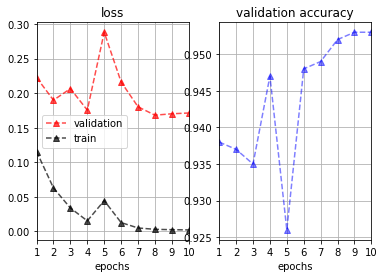

Initiate Training....

Epoch 00001: val_loss improved from inf to 0.20030, saving model to ../STL10/data/saved_models/model.best.hdf5

Epoch 00002: val_loss did not improve from 0.20030

Epoch 00003: val_loss improved from 0.20030 to 0.16526, saving model to ../STL10/data/saved_models/model.best.hdf5

Epoch 00004: val_loss improved from 0.16526 to 0.16311, saving model to ../STL10/data/saved_models/model.best.hdf5

Epoch 00005: val_loss did not improve from 0.16311

Epoch 00006: val_loss did not improve from 0.16311

Epoch 00007: val_loss improved from 0.16311 to 0.16136, saving model to ../STL10/data/saved_models/model.best.hdf5

Epoch 00008: val_loss improved from 0.16136 to 0.16031, saving model to ../STL10/data/saved_models/model.best.hdf5

Epoch 00009: val_loss improved from 0.16031 to 0.15939, saving model to ../STL10/data/saved_models/model.best.hdf5

Epoch 00010: val_loss did not improve from 0.15939
Runtime: 0 min 13 sec
8000/8000 [==============================] - 1s 120us/st

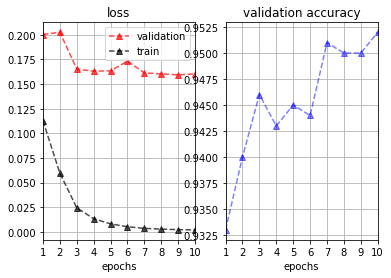

Initiate Training....

Epoch 00001: val_loss improved from inf to 0.25192, saving model to ../STL10/data/saved_models/model.best.hdf5

Epoch 00002: val_loss improved from 0.25192 to 0.18660, saving model to ../STL10/data/saved_models/model.best.hdf5

Epoch 00003: val_loss did not improve from 0.18660

Epoch 00004: val_loss did not improve from 0.18660

Epoch 00005: val_loss did not improve from 0.18660

Epoch 00006: val_loss did not improve from 0.18660

Epoch 00007: val_loss improved from 0.18660 to 0.18465, saving model to ../STL10/data/saved_models/model.best.hdf5

Epoch 00008: val_loss did not improve from 0.18465

Epoch 00009: val_loss did not improve from 0.18465

Epoch 00010: val_loss did not improve from 0.18465
Runtime: 0 min 13 sec
8000/8000 [==============================] - 1s 109us/step

At k = 3, 
Test Accuracy = 94.88 %


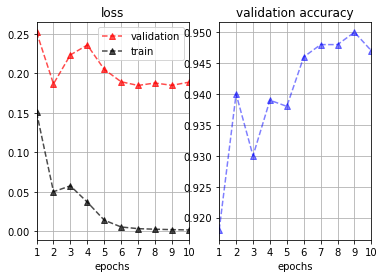

Initiate Training....

Epoch 00001: val_loss improved from inf to 0.19999, saving model to ../STL10/data/saved_models/model.best.hdf5

Epoch 00002: val_loss improved from 0.19999 to 0.17548, saving model to ../STL10/data/saved_models/model.best.hdf5

Epoch 00003: val_loss improved from 0.17548 to 0.16349, saving model to ../STL10/data/saved_models/model.best.hdf5

Epoch 00004: val_loss did not improve from 0.16349

Epoch 00005: val_loss did not improve from 0.16349

Epoch 00006: val_loss did not improve from 0.16349

Epoch 00007: val_loss did not improve from 0.16349

Epoch 00008: val_loss did not improve from 0.16349

Epoch 00009: val_loss did not improve from 0.16349

Epoch 00010: val_loss did not improve from 0.16349
Runtime: 0 min 13 sec
8000/8000 [==============================] - 1s 104us/step

At k = 4, 
Test Accuracy = 94.35 %


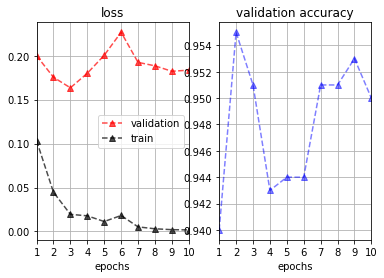

In [120]:
start = time.time()
acc = []

# ### Do a 5 k-fold
# from sklearn.model_selection import KFold
# kf = KFold(n_splits=5, shuffle=True)
# for fidx_train, fidx_cv in kf.split(train_labels_adjusted):
    
    
for k, _ in enumerate(fidx):
    fidx_cv = fidx[k]
    fidx_train = np.concatenate([fidx[0:k],fidx[k+1:]]).flatten()
    
    X_cv_features_1k = X_train_features[fidx_cv]
    y_cv_1k = y_train[fidx_cv]
    
    X_train_features_9k = X_train_features[fidx_train]
    y_train_9k = y_train[fidx_train]
    
    
    model_top = construct_model()
    if k == 0: model_top.summary()
        
    model_top, callback_inst = train_model(model_top, 
                                           X_train_features_9k, y_train_9k,
                                           X_cv_features_1k, y_cv_1k, 
                                           epochs=10,
                                           batch_size=128,
                                           wanna_plot=False)
    
    model_top.load_weights('../STL10/data/saved_models/model.best.hdf5')
    _loss, _acc = model_top.evaluate(X_test_features, y_test,batch_size=128);
    
    acc.append(_acc)
    print('\nAt k = %i, \nTest Accuracy = %.2f %%' % (k, _acc*100))

    ### Plot loss function and accuracy
    callback_inst.plotter()


    
    
#     ### 7.  Compute test accuracy.

#     _loss, _acc = model_top.evaluate(X_test_features, y_test, 
#                                     batch_size=128);
#     acc.append(_acc)
#     print('\nAt k = %i, \nTest Accuracy = %.2f %%' % (k, _acc*100))

#     ### Plot loss function and accuracy
#     callback_inst.plotter()
    


In [ ]:

print(('\n' + ('\n'+'-'*30)*2 +'\nIn %i Folds'+ '\nK-Fold Average Test Accuracy = %.2f %%  <==') % 
      (len(fidx), np.mean(acc)*100))
print_runtime(start)

# If we are to use VGG16 we need to resize the images

# Convert the training labels to categorical

In [11]:
y_train_categorical = to_categorical(train_labels_adjusted,num_classes =10)
y_train_categorical_VGG = to_categorical(train_labels_adjusted,num_classes=1000)
print(train_labels_adjusted.shape,y_train_categorical.shape)
print(y_train_categorical[5]) #gives correct one hot encoding, truck is the last class label

((5000, 1), (5000, 10))
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  1.]


In [12]:
with open('../STL10/stl10_binary/class_names.txt','r') as f:
    cnames = f.read()
cnames = cnames.split('\n')[:-1]
cnames = np.asarray(cnames) #convert class labels from list to array
print(cnames)

['airplane' 'bird' 'car' 'cat' 'deer' 'dog' 'horse' 'monkey' 'ship' 'truck']


### Change the one hot encoding to be categorical

In [13]:
'''
1. Get the argmax for each row in the one hot encoder
2. Create a set of the output in #1. This will give classes from 0 to 9
3. Loop through the set
4. Whenever #1 is same as the class being currently looped through, append that index to idx
5. We will get a 10,500 array i.e. 500 indices per class for a total of 5000 indices
'''


y = np.argmax(y_train_categorical_VGG,axis = 1)
# print(y[5]) #prints the last class which is truck and is correct
# print(max(y),min(y)) #Goes from 0 to 9 which is 10 classes
# print(set(y)) #creates a set of the classes

idx = []
for cls in set(y): #for each class label, get the indices where encoding is hot for that class
    idx.append(np.where(y==cls)[0])

# print(len(idx)) #length is 10, i.e. we get indices of images for each class
# print(len(idx[0])) #500 images
# print(len(idx[1])) #500 images
# print(len(idx[2])) #500 images

# print(type(idx)) #current dtype is list so lets convert to array
idx = np.asarray(idx)
# print(idx.shape) #10,500. We get 500 images for each class  for a total of 5000 images.
# print(type(idx))


# Now we will create our own folds for training the model

In [14]:
#
#We want to shuffle the indices for each class
'''
1.Remember that idx stored 500 ORDERED indices for each class label
2.We will first shuffle the indices for each class
3.Then let's create 5 folds per class so that we get 100 images per class per fold
'''


for num_class in range(len(idx)):
    np.random.shuffle(idx[num_class])
    
fold_idx = []
num_folds = 5
images_per_class = idx.shape[1]
fold_width = int(images_per_class/num_folds) #100 images per fold for each class i.e. 100x10 images per fold


for fold in range(num_folds):
    out = [] #fresh array for a fold
    for num_class in range(len(idx)):
        out.append(idx[num_class,fold*fold_width:(fold+1)*fold_width])
        #gets 100 images per class
    #at this stage out has 1000 images for a new fold
    np.random.shuffle(out)
    fold_idx.append(out)

fidx = np.array(fold_idx)
print(fidx.shape) # 5 folds, 10 classes per fold and 100 images per class
np.random.shuffle(fidx)

(5, 10, 100)


In [15]:
#Let's check by getting an index for the truck class
print(fidx[0,9][0])
print(fidx[0,9][1])

4852
2284


[ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0. 

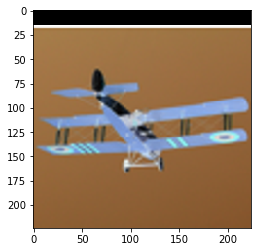

In [24]:
imshow(images_train_vgg[1039])
print(y_train_categorical[1039])
print(y_train_categorical_VGG[1039])

In [19]:
print(y_train_categorical[0])
print(y_train_categorical_VGG[0])

[ 0.  1.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0. 

In [20]:
print(y.shape)

(5000,)


[ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.]


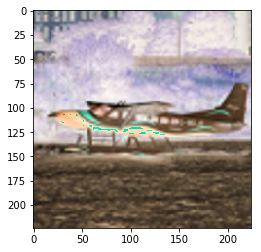

In [25]:
imshow(images_train_vgg[2723])
print(y_train_categorical[2723])

In [21]:
print(fidx[1,9][0])
print(fidx[1,9][1])

364
1458


(224, 224, 3)
[ 0.  0.  0.  0.  0.  0.  0.  1.  0.  0.]


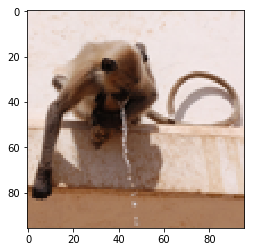

In [27]:
imshow(train_images_reshaped[2884])
print(images_train_vgg[2884].shape)
print(y_train_categorical[2884])

[ 0.  0.  0.  0.  0.  0.  0.  1.  0.  0.]


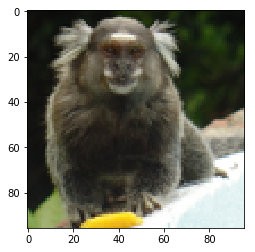

In [23]:
imshow(train_images_reshaped[2486])
print(y_train_categorical[2486])

In [30]:
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input

model_bottom = VGG16(include_top=False)

58900480/58889256 [==============================] - 2s 0us/step


In [227]:
model = Sequential()
model.add(Conv2D(64,kernel_size=3,activation='relu',input_shape=(224,96,3)))
model.add(Conv2D(64,kernel_size=3,activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(128,kernel_size=3,activation='relu'))
model.add(Conv2D(128,kernel_size=3,activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(256,kernel_size=3,activation='relu'))
model.add(Conv2D(256,kernel_size=c3,activation='relu'))
model.add(Conv2D(256,kernel_size=3,activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
# model.add(Dropout(0.2))

model.add(Flatten())

model.add(Dense(128,activation='relu'))
# model.add(Dropout(0.1))
model.add(Dense(10,activation='softmax'))
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

In [228]:
model.fit(train_images_reshaped,y_train_categorical,validation_split=0.2,epochs=5,batch_size=128, verbose=2)

Train on 4000 samples, validate on 1000 samples
Epoch 1/5
 - 317s - loss: 14.1324 - acc: 0.0973 - val_loss: 14.5224 - val_acc: 0.0990
Epoch 2/5
 - 316s - loss: 14.5023 - acc: 0.1003 - val_loss: 14.5224 - val_acc: 0.0990
Epoch 3/5
 - 316s - loss: 14.5023 - acc: 0.1003 - val_loss: 14.5224 - val_acc: 0.0990
Epoch 4/5
 - 316s - loss: 14.5023 - acc: 0.1003 - val_loss: 14.5224 - val_acc: 0.0990
Epoch 5/5
 - 316s - loss: 14.5023 - acc: 0.1003 - val_loss: 14.5224 - val_acc: 0.0990


In [10]:
fold_indices = train_file['fold_indices']
fold_indices_vector = np.squeeze(np.asarray(fold_indices))

In [11]:
print(fold_indices.shape)
print(fold_indices_vector.shape)

(1, 10)
(10,)


In [12]:
print(fold_indices[0,0].shape)
print(fold_indices_vector[0].shape)
fold_array_vector_squeezed = np.squeeze(np.asarray(fold_indices[0,0]))
print(fold_array_vector_squeezed.shape)


(1000, 1)
(1000, 1)
(1000,)


In [13]:
for i in range(10):
    print(min(fold_indices_vector[i]),max(fold_indices_vector[i]),len(fold_indices_vector[i]))


(array([1], dtype=uint16), array([4994], dtype=uint16), 1000)
(array([2], dtype=uint16), array([4995], dtype=uint16), 1000)
(array([14], dtype=uint16), array([4996], dtype=uint16), 1000)
(array([1], dtype=uint16), array([5000], dtype=uint16), 1000)
(array([1], dtype=uint16), array([4986], dtype=uint16), 1000)
(array([3], dtype=uint16), array([4999], dtype=uint16), 1000)
(array([1], dtype=uint16), array([5000], dtype=uint16), 1000)
(array([2], dtype=uint16), array([4999], dtype=uint16), 1000)
(array([8], dtype=uint16), array([4999], dtype=uint16), 1000)
(array([4], dtype=uint16), array([4999], dtype=uint16), 1000)


In [14]:
train_images_fold = np.zeros_like(np.vstack((train_images_reshaped,train_images_reshaped)))
class_labels_fold = np.zeros_like(np.vstack((class_labels,class_labels)))


print(train_images_fold.shape)
print(class_labels_fold.shape)

(10000, 96, 96, 3)
(10000, 1)


In [15]:
print(class_labels.shape)
print(class_labels[0].shape)
print(min(class_labels),max(class_labels))

(5000, 1)
(1,)
(array([1], dtype=uint8), array([10], dtype=uint8))


In [16]:
for i in range(10):
    #Let's create 1000x10 folds into a new train_image_dataset
    start_index = (i*1000) # 0,1000, 2000,...,9000
    end_index = (i*1000)+1000 #999,1999,....9999
    fold_array_vector_squeezed = np.squeeze(np.asarray(fold_indices[0,i]))
    fold_array_vector_squeezed_new = np.subtract(fold_array_vector_squeezed, 1)
    train_images_fold[start_index:end_index,:,:,:] = train_images_reshaped[fold_array_vector_squeezed_new]
    class_labels_fold[start_index:end_index,:] = class_labels[fold_array_vector_squeezed_new]
    

[7]


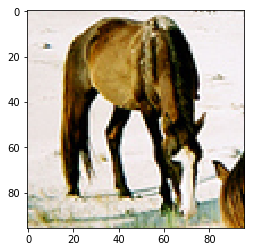

In [17]:
print(class_labels_fold[11])
imshow(train_images_fold[11])


[7]


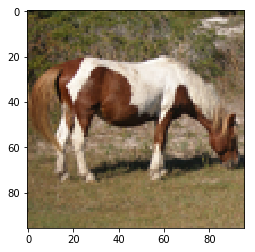

In [27]:
image_index=12
print(class_labels_fold[image_index])
imshow(train_images_fold[image_index])

In [55]:
x_train, x_test, y_train, y_test = train_test_split(train_images_fold,class_labels_fold,test_size = 0.25)

In [57]:
x_train.shape
x_train[0].shape

(96, 96, 3)

In [58]:
x_train_blackwhite = x_train[:,:,:,0]
x_train_blackwhite.shape

(7500, 96, 96)

(96, 96, 3)


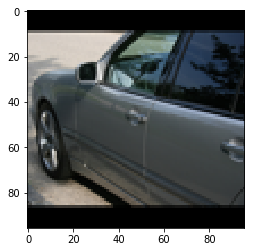

In [59]:
print(x_train[0].shape)
imshow(x_train[0])

(96, 96)


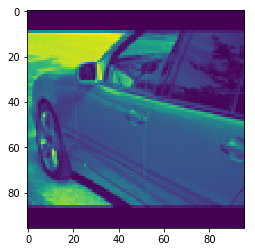

In [60]:
print(x_train_blackwhite[0].shape)
imshow(x_train_blackwhite[0])

In [61]:
print(x_train.shape)

(7500, 96, 96, 3)


In [64]:
y_train_adjusted = np.subtract(y_train,1)
print(max(y_train_adjusted))


[9]


In [66]:
y_test_adjusted = np.subtract(y_test,1)
print(max(y_test_adjusted))

[9]


In [79]:
model = Sequential()
model.add(Conv2D(20,kernel_size=3,activation='relu',input_shape=(96,96,3)))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(128,activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(10,activation='softmax'))
model.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['accuracy'])

In [75]:
print(y_test_categorical.shape)
print(y_test.shape)

(2500, 10)
(2500, 1)


In [78]:
print(y_test_adjusted[0:2])
print(y_test_categorical[0:2])

[[7]
 [4]]
[[ 0.  0.  0.  0.  0.  0.  0.  1.  0.  0.]
 [ 0.  0.  0.  0.  1.  0.  0.  0.  0.  0.]]


In [77]:
y_test_categorical[0]

array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.], dtype=float32)

In [80]:
model.fit(x_train,y_train_categorical,validation_split=0.2,epochs=10,batch_size=128, verbose=2)

ValueError: Error when checking target: expected dense_6 to have shape (1,) but got array with shape (10,)

In [244]:
#Now let's build our base network which is a CNN used for feature extraction

#We will build 2 Conv layers with ReLU activations and Max Pooling followed by a flat layer

def build_base_network(input_shape):
    
    seq = Sequential()
    
    nb_filter = [6,12]
    kernel_size = (3,3)
    
    #convolutional layer 1
    seq.add(Conv2D(nb_filter[0],kernel_size=kernel_size,input_shape = input_shape,strides=(1,1),
                          padding = 'valid',activation ='relu'))
#     seq.add(Activation('relu'))
    seq.add(MaxPooling2D(pool_size=(2,2)))
    seq.add(Dropout(0.25))
    
    #convolutional layer 2
    seq.add(Conv2D(nb_filter[1],kernel_size=kernel_size,padding='valid',strides=(1,1),activation='relu'))
#     seq.add(Activation('relu'))
    seq.add(MaxPooling2D(pool_size=(2,2),dim_ordering='th'))
    seq.add(Dropout(0.25))
    
    #flatten
    seq.add(Flatten())
    seq.add(Dense(128, activation='relu'))
    seq.add(Dropout(0.1))
    seq.add(Dense(50,activation='relu'))
    
    return seq
    
    

In [245]:
input_dim = x_train.shape[1:]
input_dim

(96, 96, 3)

In [246]:
img_a = Input(shape=input_dim)
img_b = Input(shape=input_dim)

In [247]:
base_network = build_base_network(input_dim)
feat_vecs_a = base_network(img_a)
feat_vecs_b = base_network(img_b)

/home/aishwarya105/.local/lib/python2.7/site-packages/ipykernel_launcher.py:22: UserWarning: Update your `MaxPooling2D` call to the Keras 2 API: `MaxPooling2D(data_format="channels_first", pool_size=(2, 2))`


In [248]:
feat_vecs_a.shape[0]

Dimension(None)

In [249]:
#feature vectors are the feature vectors of our input pair. 
#Next we feed these feature vectors into the energy function to compute the distance between them
#We use Euclidean distance between them

def euclidean_distance(vects):
    x,y = vects
    return k.sqrt(k.sum(k.square(x-y),axis = 1, keepdims = True))

def eucl_dist_output_shape(shapes):
    shape1, shape2 = shapes
    return (shape1[0],1)

#Lambda layer wraps an arbitrary function as a Layer object
distance = Lambda(euclidean_distance, output_shape = eucl_dist_output_shape)([feat_vecs_a,feat_vecs_b])


In [250]:
img_a.shape

TensorShape([Dimension(None), Dimension(96), Dimension(96), Dimension(3)])

In [251]:
epochs = 13
rms = RMSprop()

model = Model(input=[img_a,img_b], output = distance)

/home/aishwarya105/.local/lib/python2.7/site-packages/ipykernel_launcher.py:4: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Tensor("la..., inputs=[<tf.Tenso...)`
  after removing the cwd from sys.path.


In [252]:
def contrastive_loss(y_true, y_pred):
    margin = 1
    return k.mean((y_true) * k.square(y_pred) + (1-y_true) * k.square(k.maximum(margin - y_pred, 0)))

model.compile(loss=contrastive_loss, optimizer=rms)

In [254]:
print(x_train[0].shape)
print(x_train[1].shape)
print(x_train.shape)

(96, 96, 3)
(96, 96, 3)
(7500, 96, 96, 3)


In [255]:
img_1 = x_train[:, 0]
img_2 = x_train[:, 1] 

img_1.shape

(7500, 96, 3)

In [69]:


model.fit([img_1, img_2], y_train, validation_split=.25, batch_size=128, verbose=2, nb_epoch=epochs)

/home/aishwarya105/.local/lib/python2.7/site-packages/ipykernel_launcher.py:4: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  after removing the cwd from sys.path.


Train on 11250 samples, validate on 3750 samples
Epoch 1/13
 - 17s - loss: 0.0848 - val_loss: 0.1008
Epoch 2/13
 - 17s - loss: 0.0744 - val_loss: 0.1273
Epoch 3/13
 - 17s - loss: 0.0658 - val_loss: 0.0887
Epoch 4/13
 - 17s - loss: 0.0577 - val_loss: 0.0488
Epoch 5/13
 - 17s - loss: 0.0518 - val_loss: 0.0490
Epoch 6/13
 - 17s - loss: 0.0479 - val_loss: 0.0528
Epoch 7/13
 - 17s - loss: 0.0443 - val_loss: 0.0444
Epoch 8/13
 - 17s - loss: 0.0403 - val_loss: 0.0361
Epoch 9/13
 - 17s - loss: 0.0372 - val_loss: 0.0340
Epoch 10/13
 - 17s - loss: 0.0351 - val_loss: 0.0368
Epoch 11/13
 - 17s - loss: 0.0330 - val_loss: 0.0312
Epoch 12/13
 - 17s - loss: 0.0306 - val_loss: 0.0319
Epoch 13/13
 - 17s - loss: 0.0285 - val_loss: 0.0278


In [70]:
pred = model.predict([x_test[:, 0], x_test[:, 1]])

In [71]:
def compute_accuracy(predictions, labels):
    return labels[predictions.ravel() < 0.5].mean()

In [72]:
compute_accuracy(pred, y_test)

0.95199999999999996

In [46]:
#Defining a function to read the image

#QUESTION : Is this really needed? And if so how is the regex working??
def read_image(filename, byteorder = '>'):
    
    #first we read the image as a raw file to the buffer
    with open(filename, 'rb') as f:
        buffer = f.read()
    
    #using regex, we extract header, width, height and maxval of the image
    header, width, height, maxval = re.search(
        b"(^P5\s(?:\s*#.*[\r\n])*"
        b"(\d+)\s(?:\s*#.*[\r\n])*"
        b"(\d+)\s(?:\s*#.*[\r\n])*"
        b"(\d+)\s(?:\s*#.*[\r\n]\s)*)",buffer).groups()
        
    #then we convert the image to numpy array using np.frombuffer which interprets buffer as one dimensional array
    return np.frombuffer(buffer,
                        dtype = 'u1' if int(maxval)<256 else byteorder+'u2',
                        count = int(width)*int(height),
                        offset = len(header)
                        ).reshape((int(height), int(width)))


In [47]:
img = read_image('s1/1.pgm')
img.shape

(112, 92)

In [85]:
import os
from skimage import io
import matplotlib.pyplot as plt


In [49]:
img_os = io.imread('s1/1.pgm')

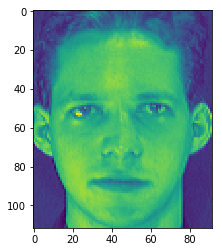

In [50]:
plt.imshow(img_os)

In [51]:
print(img_os.shape)
type(img_os)

(112, 92)


numpy.ndarray

In [52]:
img_os_new = img_os[::2,::2]
img_os_new.shape

(56, 46)

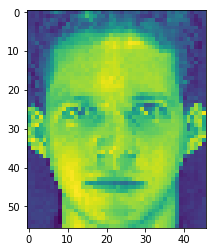

In [53]:
plt.imshow(img_os_new)

In [54]:
#Next we make x_imposite and x_genuine and concatenate to X and we make y_imposite and y_genuine and concatenate to Y

size = 2
total_sample_size = 10000

def get_data(size, total_sample_size):
    #read the image
    image = read_image('s'+str(1)+'/'+str(1)+'.pgm','rw+')
    
    #reduce the size of the image
    #QUESTION : How does this reduce the size of the image?
    #Answer: This skips every other pixel
    image = image[::size, ::size]
    
    #get the new size
    dim1 = image.shape[0]
    dim2 = image.shape[1]
    
    count = 0
    
    #initialize numpy array with the shape of [total sample, number of pairs, dim1, dim2]
    x_genuine_pair = np.zeros([total_sample_size,2,1,dim1,dim2])
    y_genuine = np.zeros([total_sample_size,1])
    
    for i in range(40):
        for j in range(int(total_sample_size/40)):
            ind1 = 0
            ind2 = 0
            
            #read two different images from same directory i.e. genuine pair
            while ind1==ind2:
                ind1 = np.random.randint(10)
                ind2 = np.random.randint(10)
                
            #read the two images
            img1 = read_image('s'+str(i+1)+'/'+str(ind1+1)+'.pgm','rw+')
            img2 = read_image('s'+str(i+1)+'/'+str(ind2+1)+'.pgm','rw+')
            
            #reduce the size
            img1 = img1[::size,::size]
            img2 = img2[::size,::size]
            
            #store the image to the initialized numpy array
            x_genuine_pair[count,0,0,:,:] = img1
            x_genuine_pair[count,1,0,:,:] = img2
            
            #because we drew from the same directory we assign label 1
            y_genuine[count] = 1
            count += 1
            
    
    count = 0
    
    x_imposite_pair = np.zeros([total_sample_size,2,1,dim1,dim2])
    y_imposite = np.zeros([total_sample_size,1])
    
    
    for i in range(int(total_sample_size/10)):
        for j in range(10):
            
            #read images from different directory (imposite pairs). Make sure ind1 is diff from ind2
            while True:
                ind1 = np.random.randint(40) #we will use this to parse through the directories
                ind2 = np.random.randint(40)
                if ind1!=ind2:
                    break
            
            
            img1 = read_image('s'+str(ind1+1)+'/'+str(j+1)+'.pgm','rw+')
            img2 = read_image('s'+str(ind2+1)+'/'+str(j+1)+'.pgm','rw+')
            
            #reduce the size
            img1 = img1[::2,::2]
            img2 = img2[::2,::2]
            
            x_imposite_pair[count,0,0,:,:] = img1
            x_imposite_pair[count,1,0,:,:] = img2
            
            #becauser we are drawing from different directory we assign label as 0
            y_imposite[count] = 0
            count += 1
            
            
            
    #now concatenate the genuine pairs and the composite pairs to get the whole data
    X = np.concatenate([x_genuine_pair,x_imposite_pair],axis = 0)/255
    Y = np.concatenate([y_genuine,y_imposite], axis = 0)
    
    return X,Y
            
            


In [55]:
X,Y = get_data(size,total_sample_size)


In [56]:
X.shape

(20000, 2, 1, 56, 46)

In [57]:
Y.shape

(20000, 1)

In [58]:
x_train, x_test, y_train, y_test = train_test_split(X,Y,test_size = 0.25)

In [76]:
x_train.shape

(15000, 2, 1, 56, 46)

In [60]:
x_train.shape

(15000, 2, 1, 56, 46)